In [1]:
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import matplotlib
import joblib
import pickle

import matplotlib.pyplot as plt

from category_encoders import TargetEncoder,OrdinalEncoder,MEstimateEncoder,JamesSteinEncoder,HashingEncoder,HelmertEncoder
from category_encoders import CatBoostEncoder,BaseNEncoder,BackwardDifferenceEncoder
from mlxtend.regressor import StackingRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import os
from scipy.stats import skew, boxcox
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

## Methodology
- My methodology for this final submission wasfrom Kaggle discussion forum https://www.kaggle.com/brahma0545/encoding-feature-comb-modkzs-1108-72665
- I took the combination of randomly selected 35 features as it was computationally efficient
- In my earlier submission I have tried building my models without outliers, but after reading most of the kaggle forum discussion I realized removing outliers is causing loss of information and leading to a worst model.
- Infact, removing outliers didn't help me much si, I decided to keep them and build a model on top of the m by taking the log of loss value and adding a shift value of 200 which gave a good stability and avoided it from skewness
- As my data was highly skewed I munged the skewness by setting some threshold of 0.25
- According to the Kaggle Forum most of them have used a different objective function which worked fairly well for optimizing our loss function.
- The objective which was used is as below
- I will brief more about the objective function used below
- In a nutshell, it is y = c * abs(x) - c**2 * np.log(abs(x)/c + 1).
- Basically, it means that MAE is not continuously differentiable so we use some approximation.In Xgboost we build some complex objective function for better optimization results.By using the below function it uses the second order derivative for further approximation.

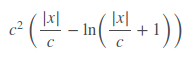

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler

import itertools

#xg_boost = joblib.load('xgboost_with_7folds')
xg_boost = joblib.load('boosting_ensemble')

shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    '''This function simply computes the ordinal value with some modifications'''
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

def func_code(X):
    '''This function will take any raw input with 130 features and will return standardised data.
    Let our data have categorical features or numerical features'''
    for comb in itertools.combinations(COMB_FEATURE,2):
        feat = comb[0] + '_' + comb[1]
        X[feat] = X[comb[0]] + X[comb[1]]
        X[feat] = X[feat].apply(encode)
    categorical_feats = [x for x in X.columns[0:] if 'cat' in x]
    for col in categorical_feats:
        X[col] = X[col].apply(encode)
        
    numeric_feats = [x for x in X.columns[1:-1] if 'cont' in x]
    ss = StandardScaler()
    X[numeric_feats] = \
        ss.fit_transform(X[numeric_feats].values)
    
    return X

def predict(X,y):
    '''Given preprocessed data this function will return predicted values with MAE'''
    X = func_code(X)
    y = np.log(y)
    X = xgb.DMatrix(X)
    pred_y = xg_boost.predict(X)
    mae = mean_absolute_error(np.exp(y),np.exp(pred_y))
    print('The predicted values',np.exp(pred_y))
    print('Mean Absolute Error',mae)
    return mae,pred_y

def predict_values(X):
    '''Given preprocessed data this function will return only predicted values'''
    X = func_code(X)
    X = xgb.DMatrix(X)
    pred_y = xg_boost.predict(X)
    pred_y = np.exp(pred_y)
    return pred_y


[16:29:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 18 ms


In [3]:
%%time
train = pd.read_csv('train.csv')
y = train['loss']
train_ = train.drop(['id','loss'],axis = 1)

Wall time: 2.08 s


In [4]:
X = train_.iloc[:7,:]
y = train['loss']
y = y.iloc[:7]
print(predict(X,y))
#print(predict_values(X))

The predicted values [2698.3157 2966.721  4381.2065 1345.6742 3704.241  5027.8755 1471.4421]
Mean Absolute Error 763.5435679408478
(763.5435679408478, array([7.900383 , 7.9952126, 8.385079 , 7.2046504, 8.217234 , 8.522753 ,
       7.2939982], dtype=float32))


In [5]:
print(predict_values(X))

[1833.4105 1628.6284 1340.6573 1507.614  1135.5469 1446.4614 1522.3138]


## Conclusion:
- I have tried multiple experiments with the above data for bringing down my performance metric MAE.
- As a part of my experimentation I tried removing the outliers and then applying PCA on all of my features including categorical.
- Unfortunately, it didn't seem to work that well.So, I tried with different featurizations on data without outliers.
- But it didn't seem to work very well as removal of outliers was loss of information and it was not fitting the model as expected.
- So, after reading alot of Kaggle discussion and related research papers I found out couple of interesting things which includes the log transform of the target variable and then using np.exp func() to take the original form in eval metric.
- Another thing I came across was combination of features and then applying the ordinality technique with some modification.
- After reading most of the Kaggle forum discussion and research paper I came across one custom objective function aka Fair Loss.
- This fair loss is an approximation of optimizing the second order derivative as MAE is not continuously differentiable.
- This Fair Loss is the whole crux of this competition and my self case study too.
- This custom objective function alone helped me in showing the drastic improvement in my MAE score with some 7 folds XGBoostRegressor.
- Whereas on the other hand my DL models didn't perform very well.
- I also tried stacking and ensemble models to improve the further score with some important features obtained from DT but I didn' have enough luck for that.
- So, atlast I settled for the rank among top 20% with 1108.71 on Public LB and 1122.50 on Private LB.
- For this final function I have written a function in such a way that given any raw input with 130 features and by raw input I mean it can consist categorical features and numerical features. My function predict will return predicted value with MAE and predict_values will only return predicted values.